In [1]:
import sys

sys.path.append('..')
from src.utils.factory import read_yaml
from src.dataset.dataset import MakeDataset
from src.models.networks import read_model
from src.ntk.generate import generate_ntk
from src.tools.train import train
from src.ntk.learning_curve import LearningCurve

/home/kwatanabe/miniconda3/envs/rnf/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Read Setting

In [2]:
cfg = read_yaml(fpath='../src/config/config.yaml')

### Prepare dataset

In [3]:
database = MakeDataset(cfg)
# get data (numpy.array)
ar_X_tr, ar_X_te, ar_y_tr, ar_y_te = database.get_array()
# get data (torch.tensor)
te_X_tr, te_X_te, te_y_tr, te_y_te = database.get_tensor()

### Read model

In [4]:
net = read_model(cfg)

### Calculate optimal learning rate

In [5]:
lr = generate_ntk(net, 0, te_X_tr, te_X_te, cfg, calc_lr=True)

100%|██████████| 80/80 [00:00<00:00, 183.57it/s]


### Train model

In [6]:
f_train_0, f_test_0, results = train(cfg, net, lr, database)

Epoch[1/1000], TrainLoss: 0.0828, TestLoss: 0.0815, TestAcc: 0.0000
Epoch[2/1000], TrainLoss: 0.0827, TestLoss: 0.0814, TestAcc: 0.0000
Epoch[3/1000], TrainLoss: 0.0825, TestLoss: 0.0812, TestAcc: 0.0000
Epoch[4/1000], TrainLoss: 0.0824, TestLoss: 0.0810, TestAcc: 0.0000
Epoch[5/1000], TrainLoss: 0.0822, TestLoss: 0.0809, TestAcc: 0.0000
Epoch[6/1000], TrainLoss: 0.0821, TestLoss: 0.0807, TestAcc: 0.0000
Epoch[7/1000], TrainLoss: 0.0819, TestLoss: 0.0806, TestAcc: 0.0000
Epoch[8/1000], TrainLoss: 0.0818, TestLoss: 0.0804, TestAcc: 0.0000
Epoch[9/1000], TrainLoss: 0.0816, TestLoss: 0.0803, TestAcc: 0.0000
Epoch[10/1000], TrainLoss: 0.0815, TestLoss: 0.0801, TestAcc: 0.0000
Epoch[11/1000], TrainLoss: 0.0813, TestLoss: 0.0800, TestAcc: 0.0000
Epoch[12/1000], TrainLoss: 0.0812, TestLoss: 0.0798, TestAcc: 0.0000
Epoch[13/1000], TrainLoss: 0.0810, TestLoss: 0.0797, TestAcc: 0.0000
Epoch[14/1000], TrainLoss: 0.0809, TestLoss: 0.0795, TestAcc: 0.0000
Epoch[15/1000], TrainLoss: 0.0807, TestLoss

### Generate NTK

In [7]:
NTK_train, NTK_test = generate_ntk(net, 0, te_X_tr, te_X_te, cfg)

100%|██████████| 20/20 [00:02<00:00,  9.02it/s]


### Make learning curve by using NTK

In [8]:
lc_base = LearningCurve(cfg, lr, NTK_train, ar_y_tr, f_train_0, f_test_0)
ntk_train_results = lc_base.train_curve()
ntk_test_results = lc_base.test_curve(NTK_test, ar_y_te, f_test_0)

100%|██████████| 1000/1000 [00:00<00:00, 5257.82it/s]


In [9]:
import numpy as np
import matplotlib.pyplot as plt

In [10]:
output = np.array(results['train_outputs'])
ntk_output = np.array(ntk_train_results['train_outputs'])

In [11]:
mean_output = output.mean(axis=1)
mean_ntk_output = ntk_output.mean(axis=1)

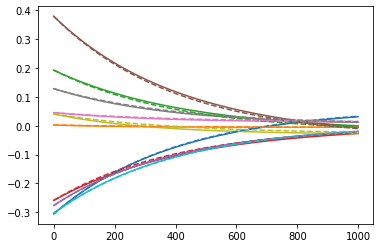

In [12]:
plt.plot(np.linspace(0, 999, 1000), mean_output)
plt.plot(np.linspace(0, 999, 1000), mean_ntk_output, linestyle='dashed');

In [34]:
n_class = output.shape[-1]
class_num = 0

m_lists = [[] for _ in range(n_class)]
for op in output:
    c = []
    for i in range(len(op)):
        if ar_y_tr[i][class_num] == max(ar_y_tr[i]):
            c.append(op[i])
            
    c_lists = [[] for _ in range(n_class)]
    for i in c:    
        for j, cl in zip(range(n_class), c_lists):
            cl.append(i[j])
            
    for m, cl in zip(m_lists, c_lists):
        m.append(np.mean(cl))

In [40]:
len(c_lists)

120